In [43]:
# Import các thư viện cần thiết
import collections  # Thư viện để sử dụng OrderedDict
import io           # Thư viện hỗ trợ đọc và ghi dữ liệu
import math         # Thư viện toán học
import os           # Thư viện cho các thao tác liên quan đến hệ điều hành
import random       # Thư viện cho các phép toán ngẫu nhiên
from six.moves import urllib  # Thư viện để tải dữ liệu từ Internet

# Import các thư viện liên quan đến hiển thị và đồ họa
from IPython.display import clear_output, Image, display, HTML  # Thư viện cho việc hiển thị dữ liệu trong IPython

# Import TensorFlow và TensorFlow Hub
import tensorflow.compat.v1 as tf  # Thư viện TensorFlow phiên bản cũ
tf.disable_v2_behavior()            # Tắt các tsính năng TensorFlow 2

import tensorflow_hub as hub  # Thư viện TensorFlow Hub cho việc sử dụng các mô hình đã được đào tạo

# Import các thư viện liên quan đến xử lý dữ liệu và đánh giá mô hình
import numpy as np             # Thư viện cho việc làm việc với mảng nhiều chiều
import matplotlib.pyplot as plt  # Thư viện cho việc vẽ biểu đồ và đồ thị
import seaborn as sns           # Thư viện cho việc vẽ biểu đồ thống kê
import sklearn.metrics as sk_metrics  # Thư viện cho việc đánh giá mô hình máy học
import time                    # Thư viện cho việc đo thời gian thực thi

In [44]:
FLOWERS_DIR = 'C:\\Users\\ngod2\\thigiacMayTinh\\main\\cats_photos'  # Đường dẫn tới thư mục chứa hình ảnh
TRAIN_FRACTION = 0.8  # Tỷ lệ dữ liệu huấn luyện so với tổng số dữ liệu
RANDOM_SEED = 2018  # Seed để làm cho quá trình ngẫu nhiên có thể tái lặp

In [45]:
def make_train_and_test_sets():
    """Chia dữ liệu thành tập huấn luyện và tập kiểm tra và lấy các lớp nhãn."""
    train_examples, test_examples = [], []  # Danh sách các ví dụ trong tập huấn luyện và tập kiểm tra
    shuffler = random.Random(RANDOM_SEED)  # Tạo một shuffler với seed cố định
    is_root = True
    classes = {}
    for (dirname, subdirs, filenames) in tf.gfile.Walk(FLOWERS_DIR):
        # Thư mục gốc chứa thông tin về các lớp mèo
        if is_root:
            subdirs = sorted(subdirs)  # Sắp xếp danh sách các thư mục con
            classes = collections.OrderedDict(enumerate(subdirs))  # Tạo một từ điển với các lớp mèo
            label_to_class = dict([(x, i) for i, x in enumerate(subdirs)])  # Tạo một ánh xạ từ nhãn đến lớp
            is_root = False
        else:
            filenames.sort()  # Sắp xếp danh sách các tệp tin ảnh
            shuffler.shuffle(filenames)  # Trộn ngẫu nhiên các tệp tin ảnh
            full_filenames = [os.path.join(dirname, f) for f in filenames]  # Đường dẫn đến các tệp tin ảnh
            label = dirname.split('\\')[-1]  # Lấy tên lớp từ đường dẫn
            label_class = label_to_class[label]  # Tìm lớp tương ứng với nhãn
            examples = list(zip(full_filenames, [label_class] * len(filenames)))  # Tạo các ví dụ
            num_train = int(len(filenames) * TRAIN_FRACTION)  # Số lượng ví dụ huấn luyện
            train_examples.extend(examples[:num_train])  # Thêm vào tập huấn luyện
            test_examples.extend(examples[num_train:])  # Thêm vào tập kiểm tra

    shuffler.shuffle(train_examples)  # Trộn ngẫu nhiên tập huấn luyện
    shuffler.shuffle(test_examples)  # Trộn ngẫu nhiên tập kiểm tra
    
    return train_examples, test_examples, classes  # Trả về các danh sách và thông tin về lớp


In [46]:
TRAIN_EXAMPLES, TEST_EXAMPLES, CLASSES = make_train_and_test_sets()
NUM_CLASSES = len(CLASSES)

In [47]:
print('\nThe dataset has %d label classes: %s' % (NUM_CLASSES, CLASSES.values()))
print('There are %d training images' % len(TRAIN_EXAMPLES))
print('there are %d test images' % len(TEST_EXAMPLES))


The dataset has 10 label classes: odict_values(['British_Longhair', 'Brittish_Shorthair', 'Muop', 'Persian', 'Ragroll', 'Scotland', 'Sphynx_Ai_Cap', 'Sphynx_Khong_Long', 'Tam_The', 'Xiem'])
There are 1567 training images
there are 396 test images


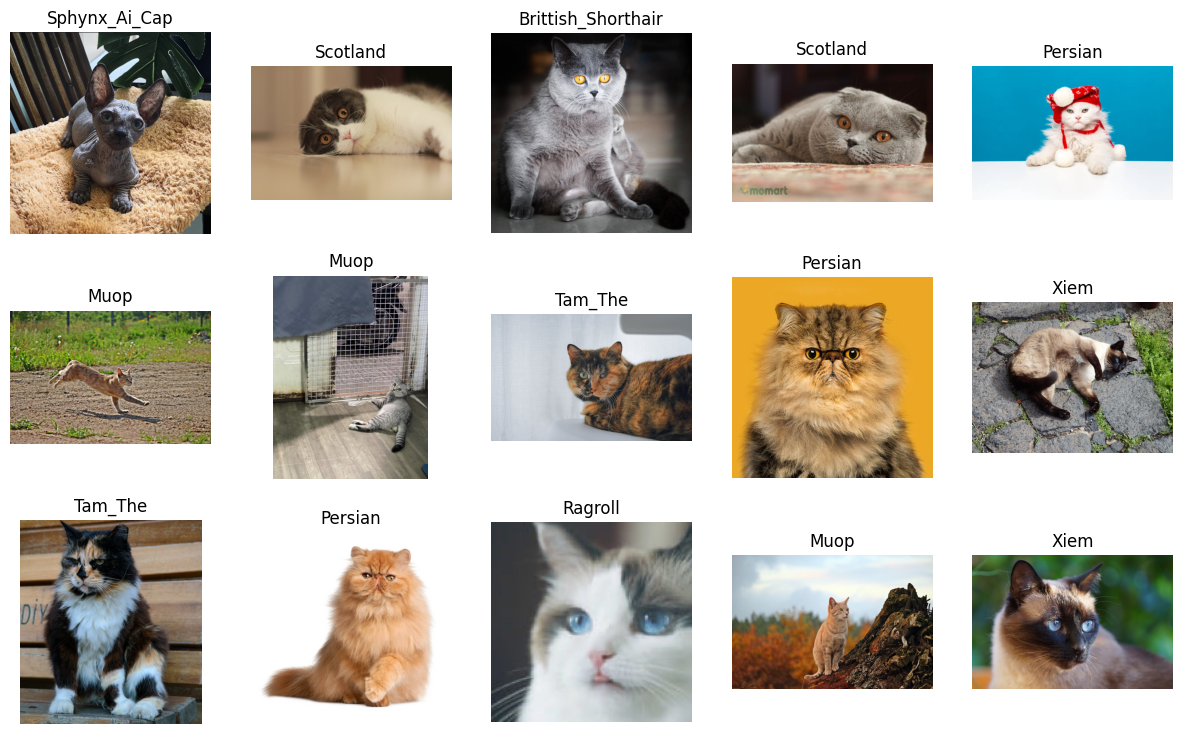

In [48]:
def get_label(example):
    """Lấy nhãn (số) cho ví dụ cụ thể."""
    return example[1]

def get_class(example):
    """Lấy lớp (chuỗi) của ví dụ cụ thể."""
    return CLASSES[get_label(example)]

def get_encoded_image(example):
    """Lấy dữ liệu hình ảnh (đã mã hóa jpg) của ví dụ cụ thể."""
    image_path = example[0]
    return tf.gfile.GFile(image_path, 'rb').read()

def get_image(example):
    """Lấy hình ảnh dưới dạng mảng np.array của các pixel cho ví dụ cụ thể."""
    return plt.imread(io.BytesIO(get_encoded_image(example)), format='jpg')

def display_images(images_and_classes, cols=5):
    """Hiển thị các hình ảnh và nhãn của chúng trong một lưới."""
    rows = int(math.ceil(len(images_and_classes) / cols))
    fig = plt.figure()
    fig.set_size_inches(cols * 3, rows * 3)
    for i, (image, flower_class) in enumerate(images_and_classes):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(image)
        plt.title(flower_class)
    plt.show()

NUM_IMAGES = 15
display_images([(get_image(example), get_class(example))
               for example in TRAIN_EXAMPLES[:NUM_IMAGES]])

In [49]:
LEARNING_RATE = 0.01  # Tốc độ học của mô hình

tf.reset_default_graph()  # Đặt lại đồ thị TensorFlow mặc định

In [50]:
# Tải một mô-đun TF-Hub được đào tạo trước để trích xuất đặc trưng từ hình ảnh.
# Chúng ta đã chọn mô-đun này vì tốc độ, nhưng có nhiều lựa chọn khác có sẵn.
image_module = hub.Module('https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/feature_vector/2')

# đây là một nút đầu vào trong đồ thị TensorFlow. Nó sẽ chứa dữ liệu hình ảnh dưới dạng chuỗi (string). shape=[None] 
# cho phép bạn truyền vào nhiều hình ảnh cùng một lúc, và số lượng hình ảnh có thể thay đổi.
encoded_images = tf.placeholder(tf.string, shape=[None])

# để lấy kích thước hình ảnh mà mô-đun hình ảnh mong đợi. Kích thước này sẽ được sử dụng để tiền xử lý hình ảnh 
# trước khi đưa chúng vào mô-đun để trích xuất đặc trưng
image_size = hub.get_expected_image_size(image_module)

In [51]:
def decode_and_resize_image(encoded):
    """Giải mã và thay đổi kích thước hình ảnh từ định dạng đã mã hóa sang float32 và kích thước mong đợi."""
    decoded = tf.image.decode_image(encoded, channels=3, expand_animations = False)
    decoded = tf.image.convert_image_dtype(decoded, tf.float32)
    return tf.image.resize_images(decoded, image_size)

# Dòng này sử dụng tf.map_fn để áp dụng hàm decode_and_resize_image lên từng hình ảnh trong encoded_images. 
# Kết quả là một tensor batch_images chứa các hình ảnh đã được giải mã và thay đổi kích thước.
batch_images = tf.map_fn(decode_and_resize_image, encoded_images, dtype=tf.float32)

# Mô-đun hình ảnh có thể được áp dụng như một hàm để trích xuất vectơ đặc trưng từ các hình ảnh đã xử lý. 
# Kết quả là features là tensor chứa các đặc trưng của các hình ảnh.
features = image_module(batch_images)

def create_model(features):
  """Xây dựng một mô hình cho việc phân loại dựa trên các đặc trưng đã trích xuất."""
  # Hiện tại, mô hình chỉ là một lớp tuyến tính duy nhất. Bạn có thể thử thêm
  # một lớp khác, nhưng hãy cẩn thận... hai lớp tuyến tính (khi activation=None)
  # tương đương với một lớp tuyến tính duy nhất. Bạn có thể tạo một lớp phi tuyến như sau:
  # layer = tf.layers.dense(inputs=..., units=..., activation=tf.nn.relu)
  layer = tf.layers.dense(inputs=features, units=NUM_CLASSES, activation=None)
  return layer

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [52]:
# Đối với mỗi lớp (loại mèo), mô hình đầu ra một số thực là điểm số
# cho biết mức độ tương tự giữa đầu vào và lớp này. Vector số này thường được gọi là "logits".
logits = create_model(features)
labels = tf.placeholder(tf.float32, [None, NUM_CLASSES])

# một cách tốt để đo lường mức độ khác biệt giữa xác suất dự đoán và thực tế
# là "cross-entropy" giữa hai phân phối xác suất. Vì sự ổn định số học, điều này tốt nhất
# nên được thực hiện trực tiếp từ logits, không phải xác suất được trích xuất từ chúng.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels)
cross_entropy_mean = tf.reduce_mean(cross_entropy)

# Hãy thêm một trình tối ưu hóa để chúng ta có thể huấn luyện mạng.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
train_op = optimizer.minimize(loss=cross_entropy_mean)

# Hàm softmax chuyển đổi vector logits thành vector xác suất: các số không âm
# mà tổng bằng một, và số thứ i nói về khả năng cao nhất rằng đầu vào thuộc lớp i.
probabilities = tf.nn.softmax(logits)

# Chúng ta chọn lớp có xác suất cao nhất là lớp dự đoán.
prediction = tf.argmax(probabilities, 1)
correct_prediction = tf.equal(prediction, tf.argmax(labels, 1))

# Độ chính xác sẽ giúp chúng ta đánh giá trên tập kiểm tra.
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Số lần huấn luyện mạng (số lô dữ liệu).
NUM_TRAIN_STEPS = 100

# Số ví dụ huấn luyện trong mỗi lô.
TRAIN_BATCH_SIZE = 10

# Tần suất đánh giá hiệu suất của mô hình.
EVAL_EVERY = 10

C:\Users\ngod2\AppData\Local\Temp\ipykernel_17716\3277934093.py:21: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  layer = tf.layers.dense(inputs=features, units=NUM_CLASSES, activation=None)


In [53]:
def get_batch(batch_size=None, test=False):
  """Lấy một lô ví dụ ngẫu nhiên."""
  examples = TEST_EXAMPLES if test else TRAIN_EXAMPLES
  batch_examples = random.sample(examples, batch_size) if batch_size else examples
  return batch_examples

def get_images_and_labels(batch_examples):
  """Lấy danh sách hình ảnh và nhãn tương ứng."""
  images = [get_encoded_image(e) for e in batch_examples]
  one_hot_labels = [get_label_one_hot(e) for e in batch_examples]
  return images, one_hot_labels

def get_label_one_hot(example):
  """Lấy mã hóa one-hot cho ví dụ."""
  one_hot_vector = np.zeros(NUM_CLASSES)
  np.put(one_hot_vector, get_label(example), 1)
  return one_hot_vector

In [54]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(NUM_TRAIN_STEPS):
    # Lấy một lô ví dụ huấn luyện ngẫu nhiên.
    train_batch = get_batch(batch_size=TRAIN_BATCH_SIZE)
    batch_images, batch_labels = get_images_and_labels(train_batch)
    # Chạy train_op để huấn luyện mô hình.
    train_loss, _, train_accuracy = sess.run(
        [cross_entropy_mean, train_op, accuracy],
        feed_dict={encoded_images: batch_images, labels: batch_labels})
    is_final_step = (i == (NUM_TRAIN_STEPS - 1))
    if i % EVAL_EVERY == 0 or is_final_step:
      # Lấy một lô ví dụ kiểm tra.
      test_batch = get_batch(batch_size=None, test=True)
      batch_images, batch_labels = get_images_and_labels(test_batch)
      # Đánh giá hiệu suất của mô hình trên tập kiểm tra.
      test_loss, test_accuracy, test_prediction, correct_predicate = sess.run(
        [cross_entropy_mean, accuracy, prediction, correct_prediction],
        feed_dict={encoded_images: batch_images, labels: batch_labels})
      print('Độ chính xác trên tập kiểm tra tại bước %s: %.2f%%' % (i, (test_accuracy * 100)))

Độ chính xác trên tập kiểm tra tại bước 0: 12.37%
Độ chính xác trên tập kiểm tra tại bước 10: 31.31%
Độ chính xác trên tập kiểm tra tại bước 20: 44.70%
Độ chính xác trên tập kiểm tra tại bước 30: 56.82%
Độ chính xác trên tập kiểm tra tại bước 40: 59.60%
Độ chính xác trên tập kiểm tra tại bước 50: 62.12%
Độ chính xác trên tập kiểm tra tại bước 60: 64.14%
Độ chính xác trên tập kiểm tra tại bước 70: 62.88%
Độ chính xác trên tập kiểm tra tại bước 80: 65.91%
Độ chính xác trên tập kiểm tra tại bước 90: 67.17%
Độ chính xác trên tập kiểm tra tại bước 99: 68.43%


In [57]:

def show_confusion_matrix(test_labels, predictions):
  """Tính ma trận nhầm lẫn và chuẩn hóa."""
  # Tính ma trận nhầm lẫn.
  confusion = sk_metrics.confusion_matrix(
    np.argmax(test_labels, axis=1), predictions)
  
  # Chuẩn hóa ma trận nhầm lẫn để có giá trị trong khoảng [0, 1].
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  
  # Xác định nhãn của trục.
  axis_labels = list(CLASSES.values())
  
  # Hiển thị ma trận nhầm lẫn dưới dạng biểu đồ nhiệt.
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  
  plt.title("Ma trận nhầm lẫn")
  plt.ylabel("Nhãn thật")
  plt.xlabel("Nhãn dự đoán")
  plt.show()

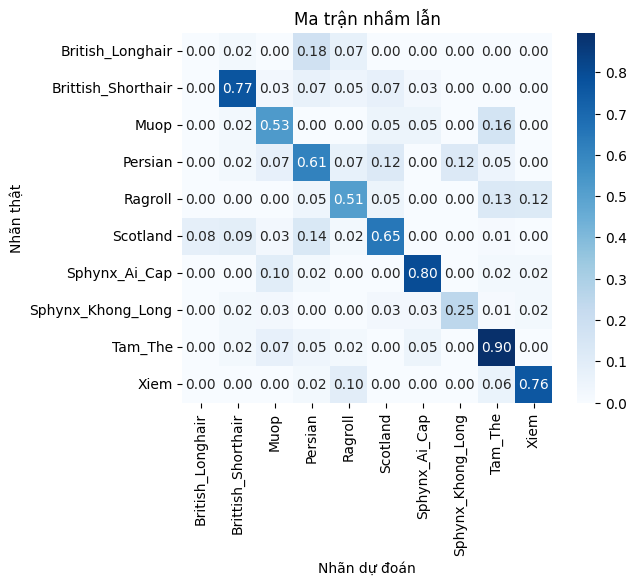

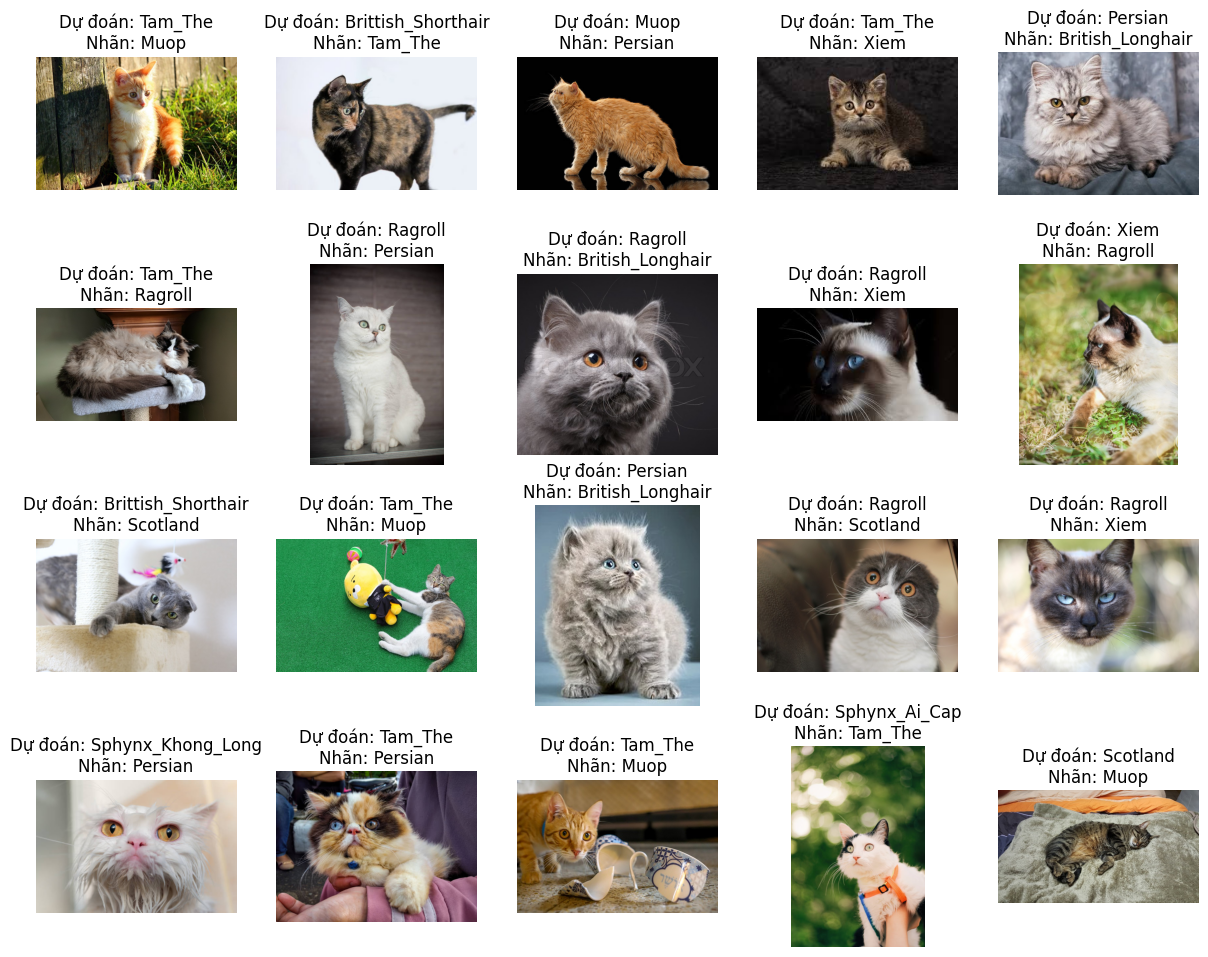

In [56]:
# Hiển thị ma trận nhầm lẫn dựa trên dữ liệu kiểm tra và dự đoán.
show_confusion_matrix(batch_labels, test_prediction)

incorrect = [
    # Tạo danh sách các ví dụ bị phân loại sai, bao gồm dữ liệu ví dụ và nhãn dự đoán sai.
    (example, CLASSES[prediction])
    for example, prediction, is_correct in zip(test_batch, test_prediction, correct_predicate)
    if not is_correct
]

# Hiển thị 20 ví dụ bị phân loại sai trong danh sách 'incorrect'.
display_images(
  # Tạo danh sách các hình ảnh và nhãn để hiển thị.
  [(get_image(example), "Dự đoán: {0}\nNhãn: {1}".format(incorrect_prediction, get_class(example)))
   for (example, incorrect_prediction) in incorrect[:20]])